Cohen, M. R., & Kohn, A. (2011). Measuring and interpreting neuronal correlations. Nature neuroscience, 14(7), 811-819.

In [1]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
from scipy import stats
import seaborn as sns
seed=2024

### Def functions

In [2]:
def align_all_trials_all_epochs(sp_sample_on,mask,neu_data,code_samples,time_before):
    alig = np.full((sp_sample_on.shape[0],sp_sample_on.shape[1]+1000),np.nan)
    t_s_off = ((code_samples[:,5] - code_samples[:,4] )+time_before).astype(int).tolist()
    t_d_off = ((code_samples[:,6] - code_samples[:,4] )+time_before).astype(int).tolist()
    max_dur_s = np.max(t_s_off)
    max_dur_d = np.max(t_d_off)
    for i in range(len(t_s_off)):
        # sample
        alig[i,:t_s_off[i]] = sp_sample_on[i,:t_s_off[i]]
        # delay
        alig[i,max_dur_s:max_dur_s+(t_d_off[i]-t_s_off[i])] = sp_sample_on[i,t_s_off[i]:t_d_off[i]]
        # test
        alig[i,max_dur_d:max_dur_d+(sp_sample_on.shape[1]-t_d_off[i])] = sp_sample_on[i,t_d_off[i]:]

    x = firing_rate.convolve_signal(arr=alig,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)

    s11_mask = neu_data.sample_id[mask] == 11
    s51_mask = neu_data.sample_id[mask] == 51
    s55_mask = neu_data.sample_id[mask] == 55
    s15_mask = neu_data.sample_id[mask] == 15
    s0_mask  = neu_data.sample_id[mask] == 0

    s11_mean = np.nanmean(x[s11_mask],axis=0)
    s51_mean = np.nanmean(x[s51_mask],axis=0)
    s55_mean = np.nanmean(x[s55_mask],axis=0)
    s15_mean = np.nanmean(x[s15_mask],axis=0)
    s0_mean  = np.nanmean(x[s0_mask ],axis=0)

    x_mean_sub = x.copy()
    x_mean_sub[s11_mask] = x_mean_sub[s11_mask]-s11_mean
    x_mean_sub[s51_mask] = x_mean_sub[s51_mask]-s51_mean
    x_mean_sub[s55_mask] = x_mean_sub[s55_mask]-s55_mean
    x_mean_sub[s15_mask] = x_mean_sub[s15_mask]-s15_mean
    x_mean_sub[s0_mask] = x_mean_sub[s0_mask]-s0_mean 

    x_no_nan = np.full(x_mean_sub.shape,np.nan)
    for i in range(x_mean_sub.shape[0]):
        no_nan = x_mean_sub[i,~np.isnan(x_mean_sub[i])]
        x_no_nan[i,:no_nan.shape[0]] = no_nan

### Analysis

In [3]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'D:/data/'#'C:/Users/camil/Documents/int/'

In [4]:
area='lip'
neu_path = basepath+'/session_struct/'+area+'/neurons/*neu.h5'
path_list = glob.glob(neu_path)

In [5]:
# Load data
n_test=1
min_trials=10
nonmatch=False
time_before=500
start=-200
end_test = n_test*450+200
end=450+200+200+end_test

idx_start = time_before + start 
idx_end = time_before+end

In [6]:
path_list[19]

'D:/data//session_struct/lip/neurons\\2023-11-17_10-48-06_Riesling_lip_e1_r1_mua6_neu.h5'

In [7]:
path_list[20]    

'D:/data//session_struct/lip/neurons\\2023-11-17_10-48-06_Riesling_lip_e1_r1_mua7_neu.h5'

In [13]:
neurons={}
for i in [19,20]:
    path = path_list[i]    
    print(path)
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on,mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    sp_sample_on = sp_sample_on[:,:time_before+460+450+300]
    sp_conv = firing_rate.convolve_signal(arr=sp_sample_on,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)
    neurons[str(i)] = {'fr':sp_sample_on,'conv':sp_conv,'path':path,'neu_data':neu_data,'mask':mask}

D:/data//session_struct/lip/neurons\2023-11-17_10-48-06_Riesling_lip_e1_r1_mua6_neu.h5
D:/data//session_struct/lip/neurons\2023-11-17_10-48-06_Riesling_lip_e1_r1_mua7_neu.h5


In [15]:
neu_data = neurons['19']['neu_data']
mask = neurons['19']['mask']
code_samples=neu_data.code_samples[mask]
code_numbers=neu_data.code_numbers[mask]
s11_mask = neu_data.sample_id[mask] == 11
s51_mask = neu_data.sample_id[mask] == 51
s55_mask = neu_data.sample_id[mask] == 55
s15_mask = neu_data.sample_id[mask] == 15
s0_mask  = neu_data.sample_id[mask] == 0

In [16]:
for i in ['19','20']:
    
    x = neurons[i]['conv']
    x_mean_sub = x.copy()
    s11_mean = np.nanmean(x[s11_mask],axis=0)
    s51_mean = np.nanmean(x[s51_mask],axis=0)
    s55_mean = np.nanmean(x[s55_mask],axis=0)
    s15_mean = np.nanmean(x[s15_mask],axis=0)
    s0_mean  = np.nanmean(x[s0_mask ],axis=0)

    # subst the mean
    x_mean_sub[s11_mask] = x_mean_sub[s11_mask]-s11_mean
    x_mean_sub[s51_mask] = x_mean_sub[s51_mask]-s51_mean
    x_mean_sub[s55_mask] = x_mean_sub[s55_mask]-s55_mean
    x_mean_sub[s15_mask] = x_mean_sub[s15_mask]-s15_mean
    x_mean_sub[s0_mask] = x_mean_sub[s0_mask]-s0_mean 

    neurons[i]['noise'] = x_mean_sub


In [17]:
neurons['19']['noise'].shape

(486, 1710)

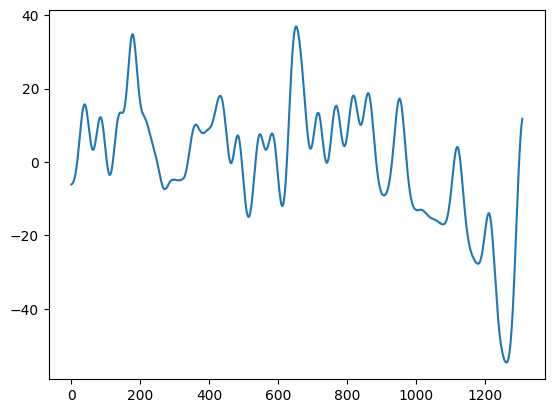

In [18]:
plt.plot(neurons['19']['noise'][s11_mask,400:][0])

In [19]:
n19 = neurons['19']['noise'][s11_mask,400:450+400].T
n20 = neurons['20']['noise'][s11_mask,400:450+400].T
size = n19.shape[0]
corr_matrix = np.corrcoef(n19,n20).round(decimals=3)[0:size,size:]

In [20]:
corr_matrix

array([[ 0.028,  0.029,  0.03 , ..., -0.091, -0.09 , -0.089],
       [ 0.032,  0.033,  0.035, ..., -0.09 , -0.089, -0.089],
       [ 0.035,  0.037,  0.039, ..., -0.089, -0.089, -0.088],
       ...,
       [ 0.042,  0.041,  0.04 , ..., -0.102, -0.102, -0.102],
       [ 0.034,  0.032,  0.031, ..., -0.093, -0.093, -0.093],
       [ 0.026,  0.025,  0.023, ..., -0.083, -0.083, -0.083]])

<Axes: >

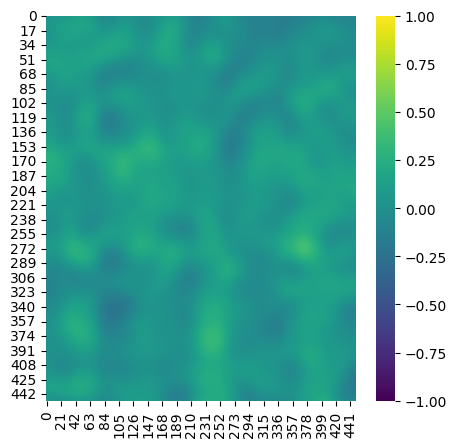

In [21]:
plt.subplots(figsize=(5,5))
sns.heatmap(corr_matrix,vmax=1,vmin=-1,cmap='viridis')